# Neuronal culture coupled with HD-MEA

Dissociated neurons from the hippocampus of rat embryio.<br>
Cells were plated on MaxOne HD-MEA (26k electrodes, 1k simultaneously addressable) and self organized in a network in few weeks. <br>

### 1. Spontaneous activity recording

Data presented here: 5 minutes of spontaneous activity recorded after selecting a map of ~900 channels within the 26,400 electrode-grid chip. <br> After an Activity Scan phase, channel map was selected in correspondence of the most active areas of the chip.

#### Spike detection

Spikes were detected by setting a threshold of 6 standard deviations over the noise baseline of the RAW signal.
<br>

Data presented here were NOT spike sorted.
<br>
For spike sorting, the usage of kilosort4 (https://kilosort.readthedocs.io/en/latest/) is recommended. <br>
To optimize the performance, the acquisition modality Network Assay in the MaxLive Scope is strongly recommended.

### 2. Effective connectivity

We show here the effective connectivity computed with the EC-package < url >.
<br>
Three metrics are visualized here: Delayed Transfer Entropy (TE), Signed Cross-Correlation (SC) and Cross-Covariance (XCov).
<br><br>

### utils/ package

- utils/SpikeDataProcessor.py  :  class to load spike trains acquired during spontaneous (and evoked) activity.
- utils/load_data.py           :  to load the chip features (channel IDs, channel map, ...) from Cult.mat file
- utils/load_EC.py             :  to load the EC-package outputs (.mat format)



In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.io

#=================================================================================================#

from utils import load_data as ld
from utils import load_EC as lec

from utils import spikeDataProcessor as SDP
from utils import plot as pl

#=================================================================================================#

# Functions

In [2]:
#=================================================================================================#
# For Avenir font. To use it, you have to download the font-style files below.
# Comment the lines referred to fontManager if you don't need to set the font.
from matplotlib import font_manager, rcParams
font_file   = "/home/tentori/.local/avenir_ff/AvenirLTStd-Roman.otf"
font_file_b = "/home/tentori/.local/avenir_ff/AvenirLTStd-Black.otf"
font_file_c = "/home/tentori/.local/avenir_ff/AvenirLTStd-Book.otf"
font_manager.fontManager.addfont(font_file)
font_manager.fontManager.addfont(font_file_b)
font_manager.fontManager.addfont(font_file_c)

rcParams['font.family']  = "Avenir LT Std"
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype']  = 42

DIM = 22
plt.rcParams.update({
    'font.size': DIM,
    'axes.labelsize': DIM,
    'axes.titlesize': DIM,
    'xtick.labelsize': DIM,
    'ytick.labelsize': DIM
})
#=================================================================================================#

show_plot   = True

#=================================================================================================#

# to create folder
def Set_Dir_Plots(path):
    import os
    if not os.path.exists(path):
        os.mkdir(path)

In [3]:
def plot_counts(mat, cmap='viridis', title=None, xlabel='time (s)', ylabel='channel ID', cbarlabel='spike couunt', 
                    inevert_y : bool = True, figsize=(15,5)):
    mat_max = np.max(mat.flatten()) # normalize max to 1 – totally optional
    
    # percentile boundaries - for better visualization
    vmin,vmax = np.percentile(mat.flatten()/mat_max,[2.5,97.5])
    
    fig,ax = plt.subplots(figsize=figsize)
    im = ax.imshow(mat/mat_max, aspect='auto', vmin=vmin,vmax=vmax, cmap=cmap)
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if title:
        plt.title(title)
    cbar = fig.colorbar(im, ax=ax, label=cbarlabel)
    if inevert_y:
        ax.invert_yaxis()

# Parameters

In [4]:
main_path    = '../Data_MaxOne/'
sim_folder   = 'Culture1REC0/'
path_results = '../Output_MaxOne/'

#=== parameters spontaneous activity ===#

# MaxOne sampling frequency
fs         = 20000     # (Hz)
ms_bins    = 20        # number of samples in a ms

# recording length (sec)
T_spont    = 300

# binsize to compute spike counts
bin_sz      = 0.01

# P-value threshold for EC
alpha_th   = 0.001

# 1. Data load

In [5]:
#=================================================================================================#
#                             M A P   F E A T U R E S   L O A D I N G                             #

# map features: 
# channel: channel IDs
# cluster: cluster IDx for channel groups - 3x3 grid (related to channel array)
# pos:     coordinates of channels (related to channel array)

_, channel, _, pos, cluster, _, _, _ = ld.load_original_data(main_path, sim_folder)
channel = channel - 1

In [6]:
#=================================================================================================#
#                            L O A D   S P I K E   T R A I N S   D A T A                          #                                       #

processor  = SDP.SpikeDataProcessor(main_path, sim_folder,  T_cutoff = T_spont, stim_ST=None, stim_CH=None)

data_original = processor.get(mode='original'); print(data_original.keys())
data_sorted   = processor.get(mode='sorted')
data_sub      = processor.get(mode='subsampled')
data_agg      = processor.get(mode='aggregated')


dict_keys(['spikes', 'channel', 'cluster', 'electrode', 'position', 'stim_channel', 'stim_position', 'rate'])


In [7]:
# counting spikes in bins

binsize = 0.001

#data_original['counts'] = SDP.compute_spike_counts(data_original['spikes'], binsize=binsize)
data_sorted['counts']   = SDP.compute_spike_counts(data_sorted['spikes'], binsize=binsize)
data_sub['counts']      = SDP.compute_spike_counts(data_sub['spikes'], binsize=binsize)
data_agg['counts']      = SDP.compute_spike_counts(data_agg['spikes'], binsize=binsize)

## 1.1 spike counts

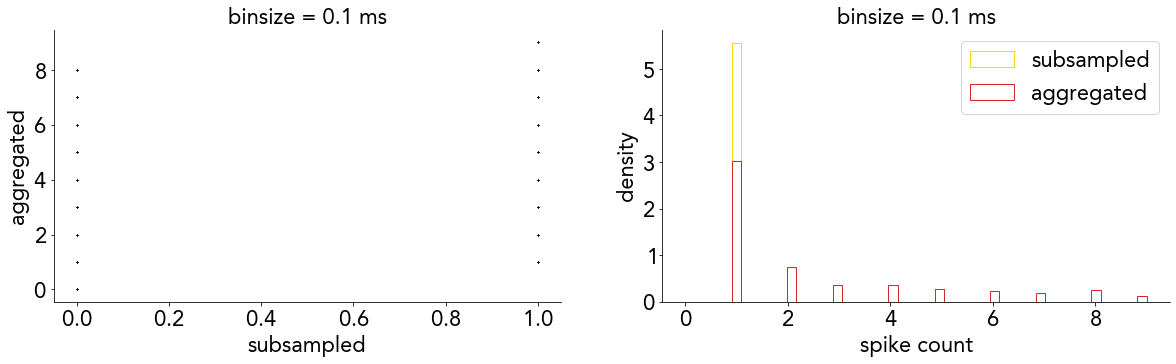

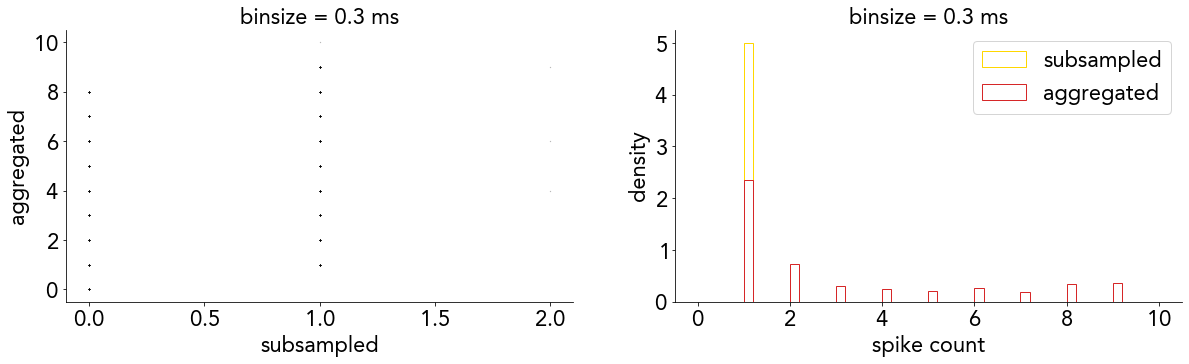

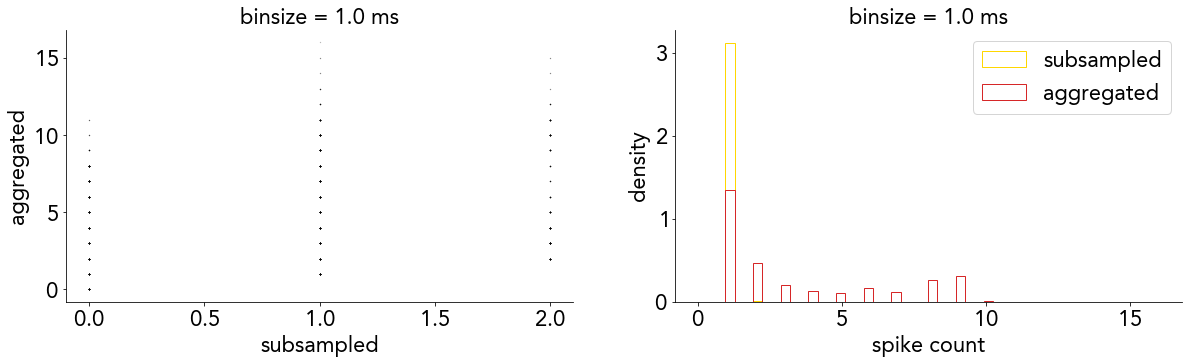

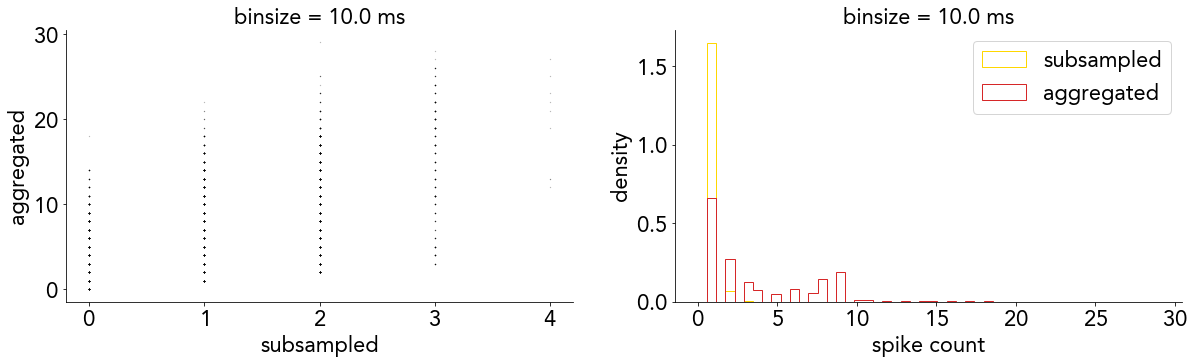

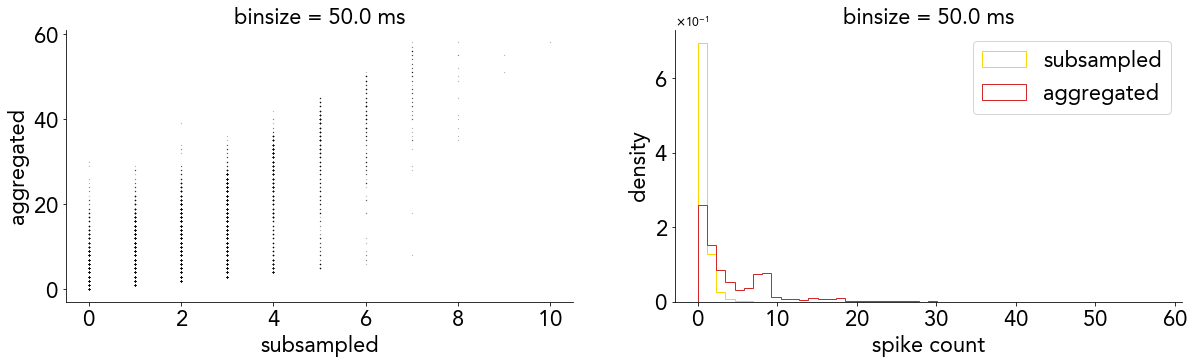

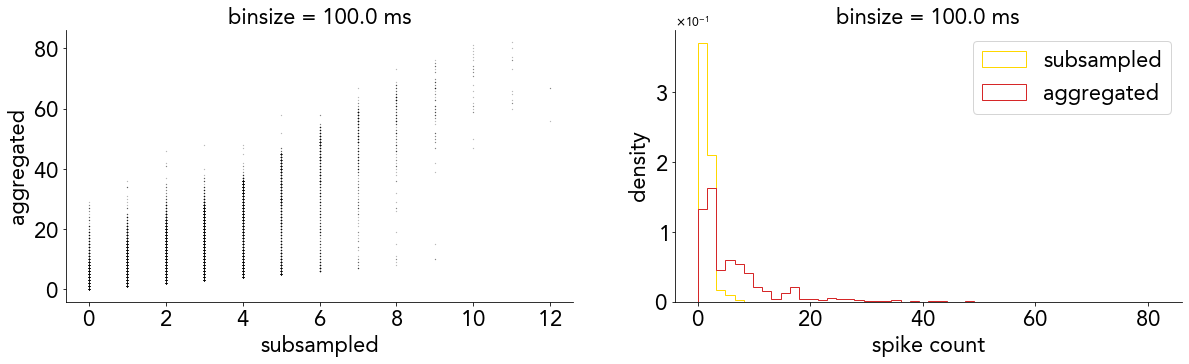

In [39]:
# spike counts for different bin-sizes

for bs in [0.0001,0.0003,0.001,0.01,0.05,0.1]: # seconds

    sc_sub = SDP.compute_spike_counts(data_sub['spikes'], binsize=bs)
    sc_agg = SDP.compute_spike_counts(data_agg['spikes'], binsize=bs)
    counts_sub = (sc_sub.T).flatten()
    counts_agg = (sc_agg.T).flatten()
    
    fig,axs = plt.subplots(1,2, figsize=(20,5))
    ax = axs[0]
    ax.scatter(counts_sub,counts_agg,s=0.05, c='k',alpha=0.5)
    ax.set_xlabel('subsampled')
    ax.set_ylabel('aggregated')
    pl.set_format(ax=ax, pwr_x_max=3, pwr_y_max=3, DIM=DIM)
    ax.set_title(f'binsize = {(bs*1000)} ms')

    ax = axs[1]
    max_h = np.max(counts_agg)
    ax.hist(counts_sub[counts_sub!=0], 50, [0,max_h], density=True, color='gold',    histtype='step', label='subsampled')
    ax.hist(counts_agg[counts_sub!=0], 50, [0,max_h], density=True, color='tab:red', histtype='step', label='aggregated')
    ax.set_xlabel('spike count')
    ax.set_ylabel('density')
    pl.set_format(ax=ax, pwr_x_max=3, pwr_y_max=3, DIM=DIM)
    ax.set_title(f'binsize = {(bs*1000)} ms')
    ax.legend()

## 1.2 Recording channel map

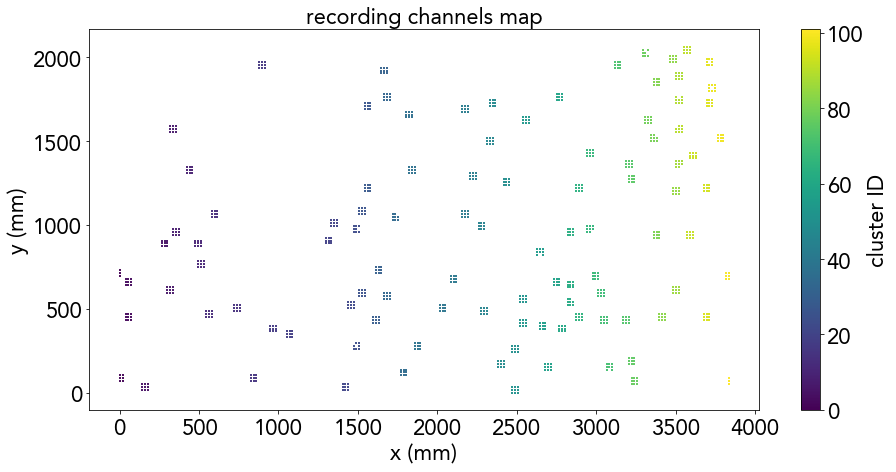

In [8]:
# channel map on the chip: ~900 channels selected within the 26,400 electrodes grid
# colormap: clusters (group of 3x3) of channels
pl.plot_map(pos, cluster, cbar_label='cluster ID', title='recording channels map', cmap='viridis', 
         outf = None, show_plot = show_plot)

### 1.2.1 rate - channel map

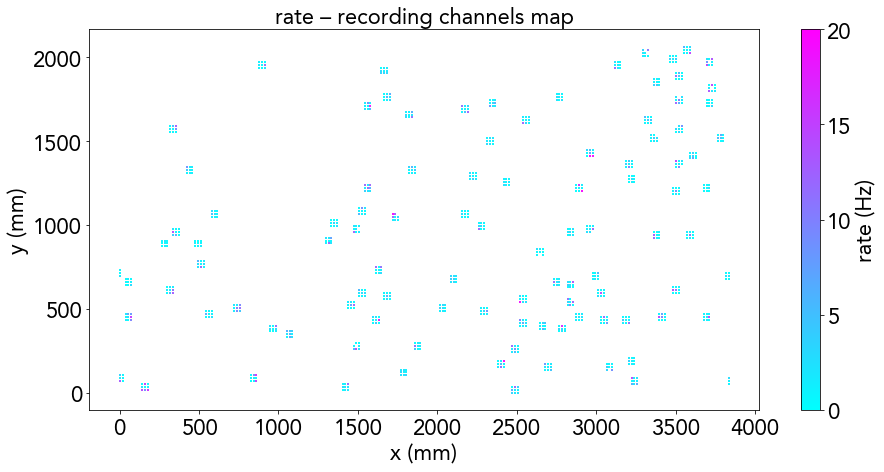

In [9]:
# channel map  –  colormap: firing rate
pl.plot_map(pos, data_sorted['rate'], cbar_label='rate (Hz)', title='rate – recording channels map',
         cmap='cool', outf = None, show_plot = show_plot)


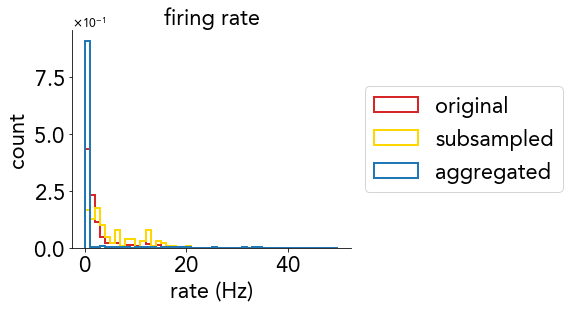

In [40]:
fig,ax = plt.subplots(figsize=(5,4))
h=plt.hist(data_sorted['rate'], 50, [0,50], density=True, lw=2, color='tab:red',  histtype='step', label='original')
h=plt.hist(data_sub['rate'],    50, [0,50], density=True, lw=2, color='gold',     histtype='step', label='subsampled')
h=plt.hist(data_agg['rate'],    50, [0,50], density=True, lw=2, color='tab:blue', histtype='step', label='aggregated')
ax.set_xlabel('rate (Hz)')
ax.set_ylabel('count')
pl.set_format(ax=ax,pwr_x_max=3,pwr_y_max=3,DIM=DIM)
xt=ax.set_title('firing rate')
xt=ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), borderaxespad=0.)


## 1.3 Spontaneous activity recording

### 1.3.1 Sort channels by cluster

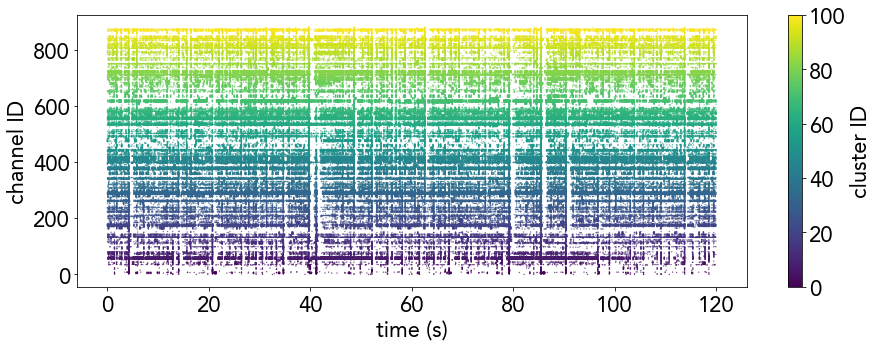

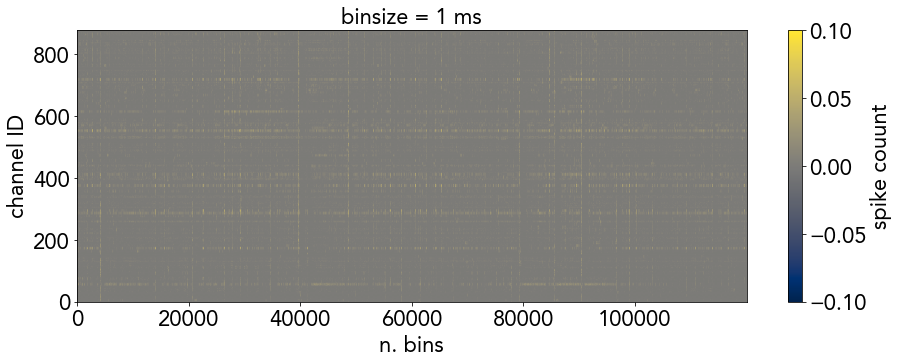

In [11]:
st = data_sorted['spikes'];   ch = data_sorted['channel'];   cl = data_sorted['cluster'];   sc = data_sorted['counts']
pl.rasterplot(st, ch, cl) # color of the train corresponds to the cluster (grid 3x3) number in the channel map

Tmax = int(120/binsize)
plot_counts((sc.T)[:,:Tmax], cmap='cividis', xlabel = 'n. bins', title='binsize = '+str(int(binsize*1000))+' ms')


### 1.3.2 Subsampling: pick the channel with max firing rate in each cluster

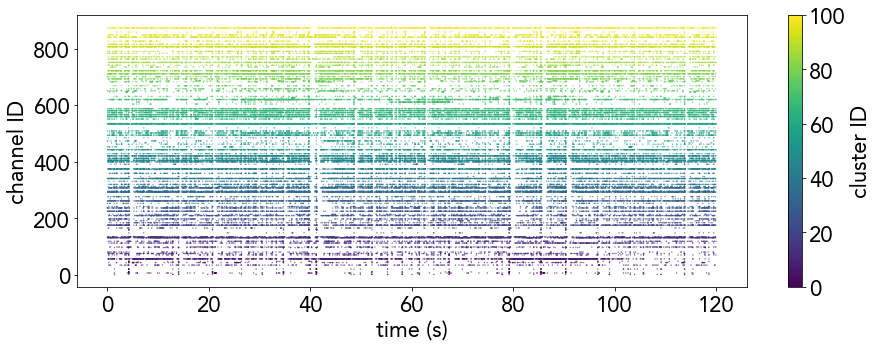

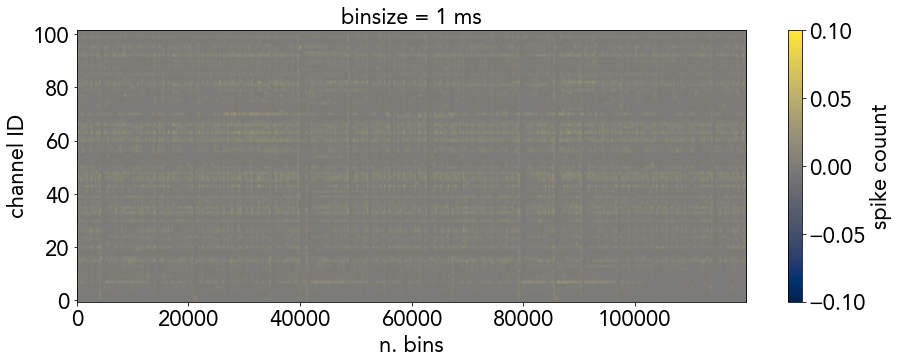

In [12]:
st = data_sub['spikes'];   ch = data_sub['channel'];   cl = data_sub['cluster'];   sc = data_sub['counts']
pl.rasterplot(st, ch, cl) #cmap=Cmap('glasbey')

Tmax = int(120/binsize)
plot_counts((sc.T)[:,:Tmax], cmap='cividis', xlabel = 'n. bins', title='binsize = '+str(int(binsize*1000))+' ms')


### 1.3.3 Data Aggregation: put together the spikes channels in a cluster

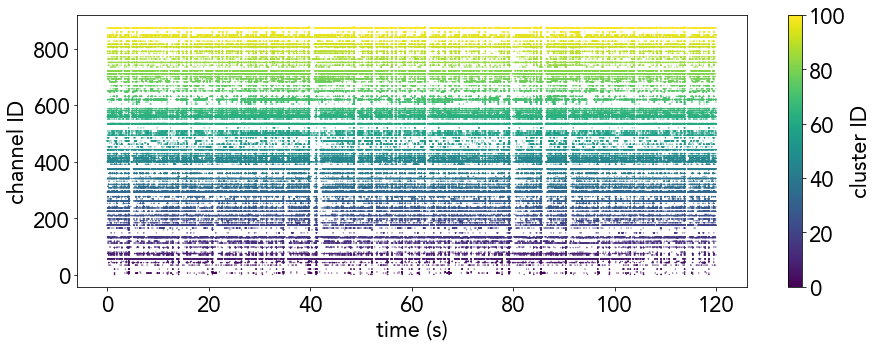

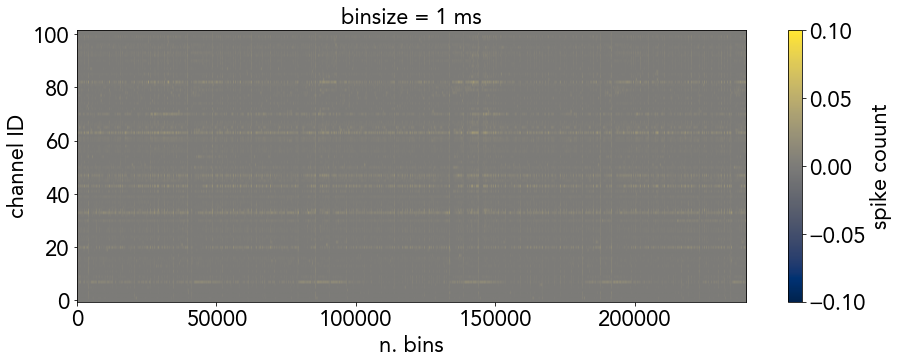

In [13]:
st = data_agg['spikes'];    ch = data_agg['channel'];    cl = data_agg['cluster'];   sc = data_agg['counts']
pl.rasterplot(st, ch, cl)#Cmap('glasbey')

Tmax = int(120/binsize)
plot_counts((sc.T)[:,:Tmax*2], cmap='cividis', xlabel = 'n. bins', title='binsize = '+str(int(binsize*1000))+' ms')


# 2. effective connectivity

## 2.1 data load

In [14]:
TE,  TE_sign,  zTE,  zTE_sign, TE_Pval   = lec.load_complete_measures(path_results, sim_folder, file_prefix='Cult_', 
                                                                      ECmeas = 'TE',  tp = 'pk', alpha=alpha_th)
SC,  SC_sign,  zSC,  zSC_sign, SC_Pval   = lec.load_complete_measures(path_results, sim_folder, file_prefix='Cult_', 
                                                                      ECmeas = 'SC',  tp = 'pk', alpha=alpha_th)
XCov,  XCov_sign,  zXCov,  zXCov_sign, XCov_Pval   = lec.load_complete_measures(path_results, sim_folder, file_prefix='Cult_', 
                                                                      ECmeas = 'XCov',  tp = 'pk', alpha=alpha_th)


## 2.2 EC matrices visualization 

### 2.2.1 Sort channels by cluster

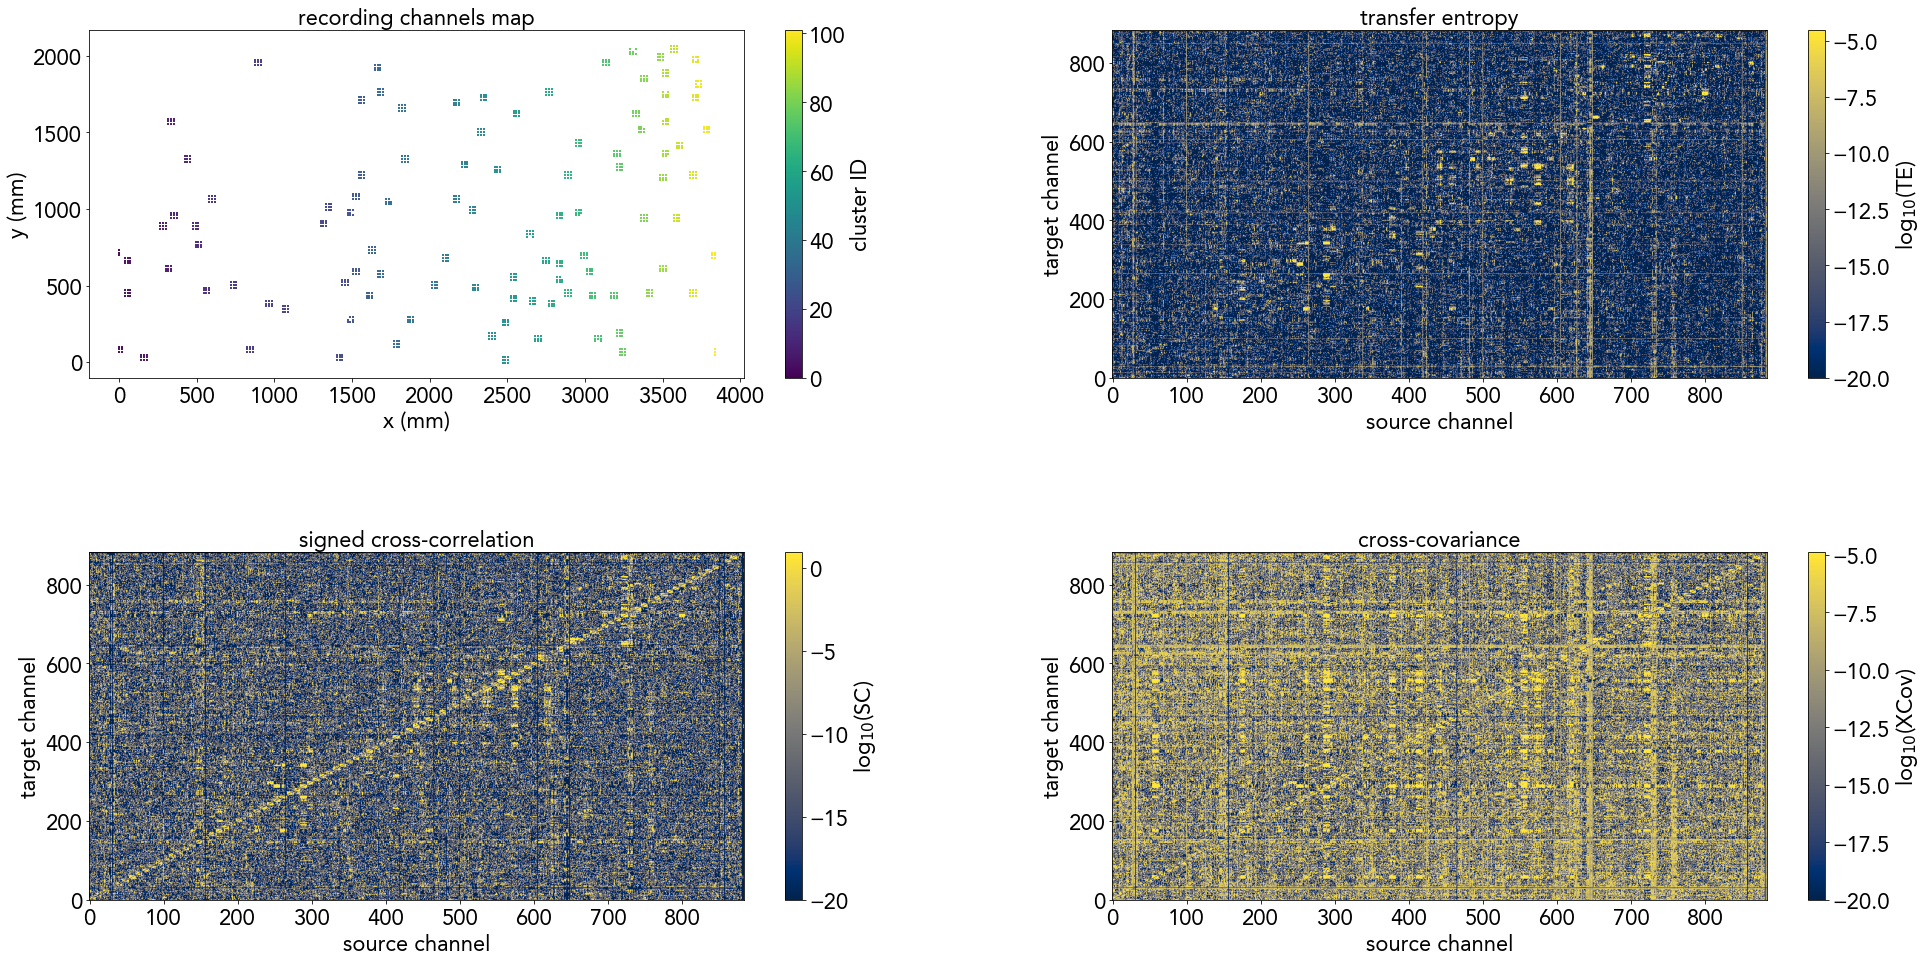

In [15]:
# argsort by cluster ID
L = np.argsort(cluster)

# ----------------------

fig, axs = plt.subplots(2,2,figsize=(33,16))

pl.plot_map(pos, cluster, cbar_label='cluster ID', title='recording channels map', cmap='viridis', 
         ax=axs[0,0], outf = None, show_plot = show_plot)

_min = np.min((TE_sign[np.ix_(L,L)])[(TE_sign[np.ix_(L,L)])!=0])
pl.plot_mat_aspect(np.log10(TE_sign[np.ix_(L,L)]+1E-20).T, #vmin=-6,vmax=np.max(mat.flatten()), 
                ylabel='target channel', xlabel='source channel', cbarlabel='log$_{10}$(TE)', title='transfer entropy', 
                cmap='cividis', ax=axs[0,1], outf = None, show_plot = show_plot)

mat = np.log10(np.abs(SC_sign[np.ix_(L,L)].T)+1E-20)
_min = np.min(np.abs(SC_sign[np.ix_(L,L)])[np.abs(SC_sign[np.ix_(L,L)])!=0])
pl.plot_mat_aspect(mat, #vmin=np.log10(_min), vmax=np.max(mat.flatten()), 
                ylabel='target channel', xlabel='source channel', cbarlabel='log$_{10}$(SC)', title='signed cross-correlation',
                cmap='cividis', ax=axs[1,0], outf = None, show_plot = True)

mat = np.log10(np.abs(XCov_sign[np.ix_(L,L)])+1E-20).T
_min = np.min(np.abs(XCov_sign[np.ix_(L,L)])[np.abs(XCov_sign[np.ix_(L,L)])!=0])
pl.plot_mat_aspect(mat, #vmin=-7, vmax=np.max(mat.flatten()), 
                ylabel='target channel', xlabel='source channel', cbarlabel='log$_{10}$(XCov)', title='cross-covariance',
                cmap='cividis', ax=axs[1,1], outf = None, show_plot = True)

fig.subplots_adjust(wspace=0.25, hspace=0.5)

### 2.2.2 Subsampling: pick the channel with max firing rate in each cluster

In [16]:
sub_ids = processor._subsample_indices(data_original)

sub_TE_sign   = TE_sign[np.ix_(sub_ids,sub_ids)]
sub_SC_sign   = SC_sign[np.ix_(sub_ids,sub_ids)]
sub_XCov_sign = XCov_sign[np.ix_(sub_ids,sub_ids)]

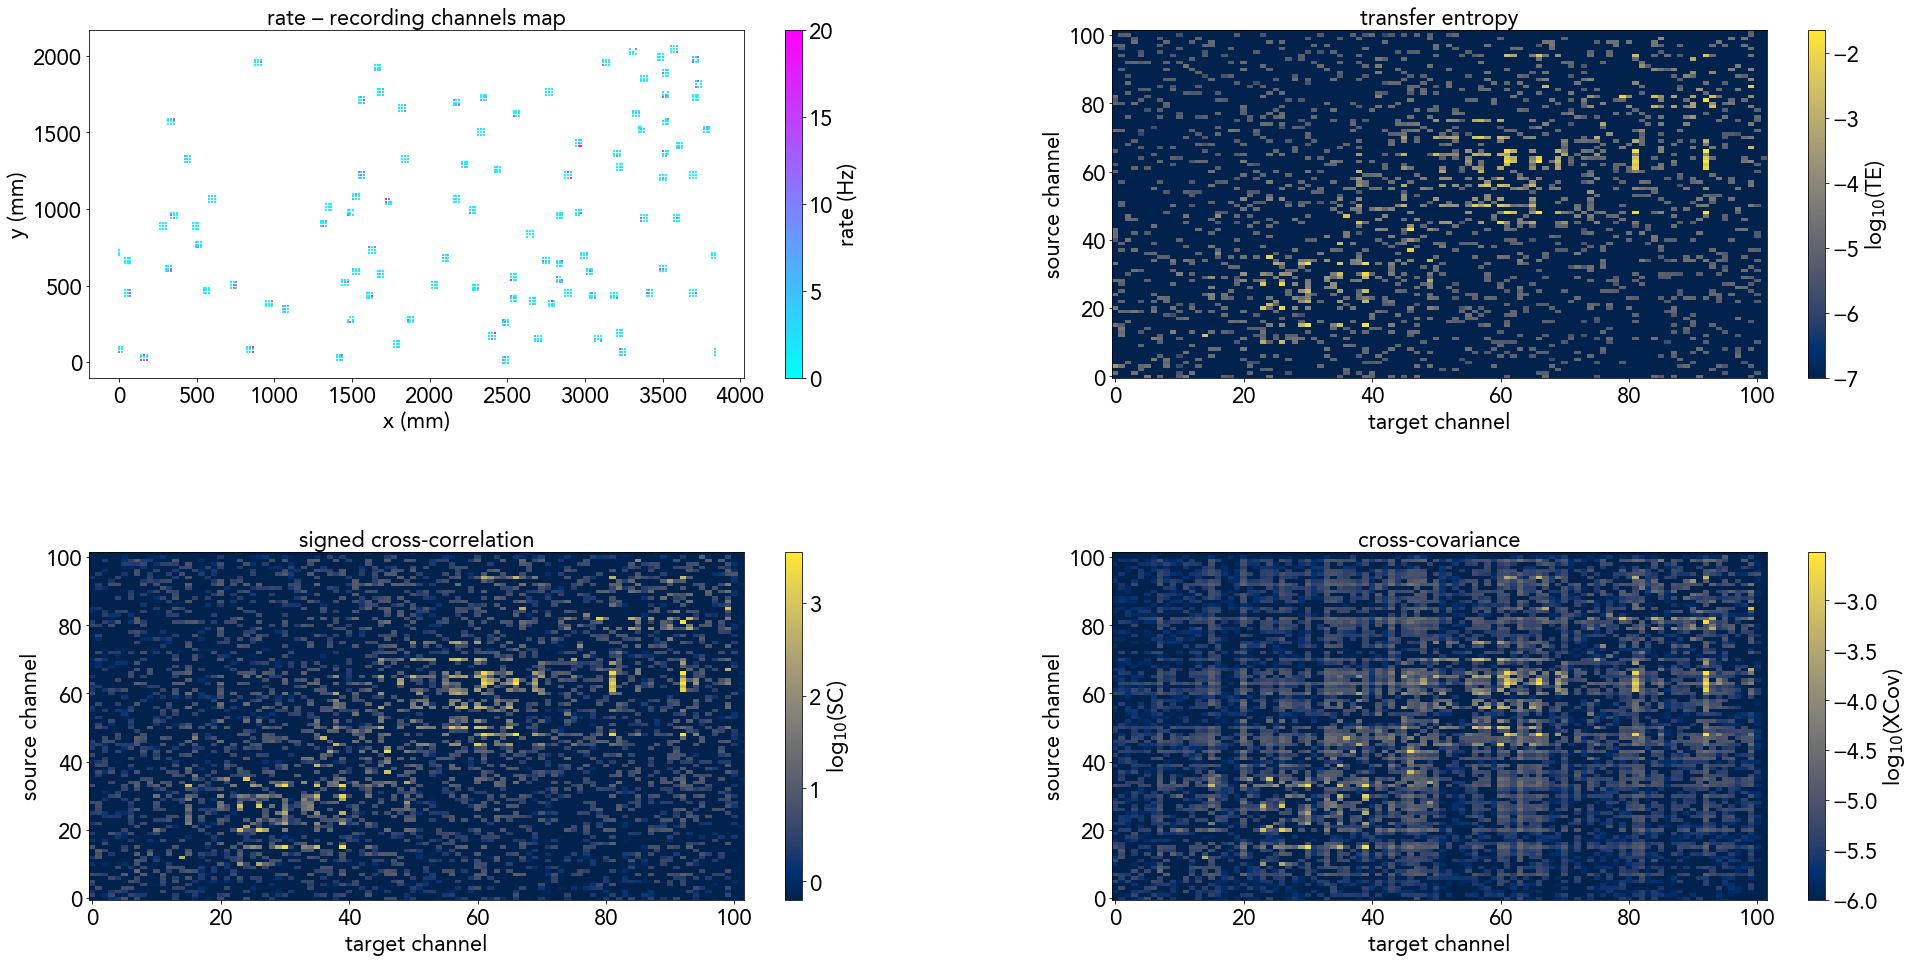

In [17]:
fig, axs = plt.subplots(2,2,figsize=(33,16))

pl.plot_map(pos, data_sorted['rate'], cbar_label='rate (Hz)', title='rate – recording channels map',
         cmap='cool', ax=axs[0,0], outf = None, show_plot = show_plot)

mat = np.log10(sub_TE_sign+1E-20)
pl.plot_mat_aspect(mat, vmin=-7,vmax=np.max(mat.flatten()),
                xlabel='target channel', ylabel='source channel', cbarlabel='log$_{10}$(TE)', title='transfer entropy', 
                cmap='cividis', ax=axs[0,1], outf = None, show_plot = show_plot)

mat = np.log10(np.abs(sub_SC_sign)+1E-20)
_min = np.min(np.abs(sub_SC_sign)[np.abs(sub_SC_sign)!=0])
pl.plot_mat_aspect(mat, vmin=-0.2, vmax=np.max(mat.flatten()),
                xlabel='target channel', ylabel='source channel', cbarlabel='log$_{10}$(SC)', title='signed cross-correlation',
                cmap='cividis', ax=axs[1,0], outf = None, show_plot = True)

mat = np.log10(np.abs(sub_XCov_sign)+1E-20)
pl.plot_mat_aspect(mat,  vmin=-6, vmax=np.max(mat.flatten()),
                xlabel='target channel', ylabel='source channel', cbarlabel='log$_{10}$(XCov)', title='cross-covariance',
                cmap='cividis', ax=axs[1,1], outf = None, show_plot = True)

fig.subplots_adjust(wspace=0.25, hspace=0.5)

## 3. Weights distribution

In [21]:
colorz    = ['#255D93','#5FA6D6','#B02106','#F24D33','#2C2C2C','#787878']


In [32]:
def hist(vec, n_bins=100, color='tab:blue', xlabel='EC', ylabel='count', ymax=None, density=False, 
         bin_range=[-1,1], title=None, ax=None, outf : str = None, show_plot = True):
    if ax is None:
        fig,ax = plt.subplots()
    else:
        fig = ax.get_figure() 
        
    h=ax.hist(vec,n_bins,bin_range,density=density, color=color)
    pl.set_format(ax=ax,DIM=DIM, pwr_y_max=3)
    ax.set_xlabel(xlabel); ax.set_ylabel(ylabel)
    
    if ymax:
        ax.set_ylim(0,ymax)
    if title:
        ax.set_title(title)
        
    if ax is None:
        if outf:
            ax.savefig(outf, bbox_inches='tight')
            if not show_plot:
                plt.close()
        else:
            plt.show()

## 3.1 TE

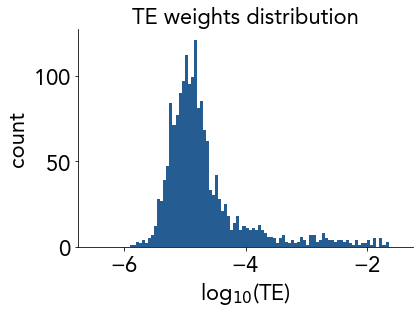

In [33]:
mat = np.log10(sub_TE_sign+1E-20)
hist(mat[mat>-7], color=colorz[0], bin_range=[-6.5,-1.5], xlabel='log$_{10}$(TE)', ylabel='count', density=False, title='TE weights distribution')


## 3.2 SC

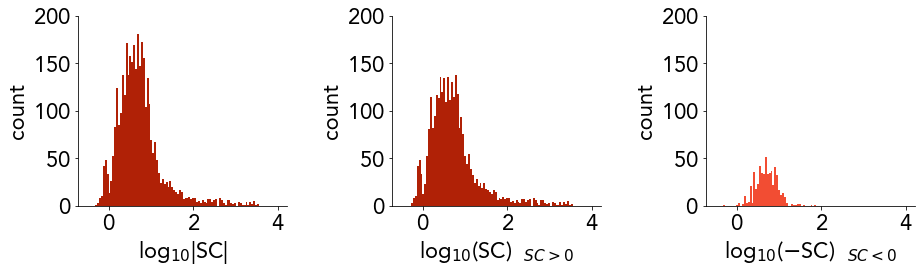

In [35]:
fig,axs=plt.subplots(1,3,figsize=(15,3.5))

mat = np.log10(np.abs(sub_SC_sign[sub_SC_sign!=0]))
hist(mat.flatten(), color=colorz[2], bin_range=[-0.5,4], xlabel='log$_{10}$|SC|', 
     ylabel='count', ymax=200, ax=axs[0], density=False)


mat = np.log10(np.abs(sub_SC_sign[sub_SC_sign>0]))
hist(mat.flatten(), color=colorz[2], bin_range=[-0.5,4], xlabel='log$_{10}$(SC)  $_{SC>0}$', 
     ylabel='count', ymax=200, ax=axs[1], density=False)

mat = np.log10(np.abs(sub_SC_sign[sub_SC_sign<0]))
hist(mat.flatten(), color=colorz[3], bin_range=[-0.5,4], xlabel='log$_{10}$($-$SC)  $_{SC<0}$', 
     ylabel='count', ymax=200, ax=axs[2], density=False)

fig.subplots_adjust(wspace=0.5, hspace=0.5)


## 3.3 XCov

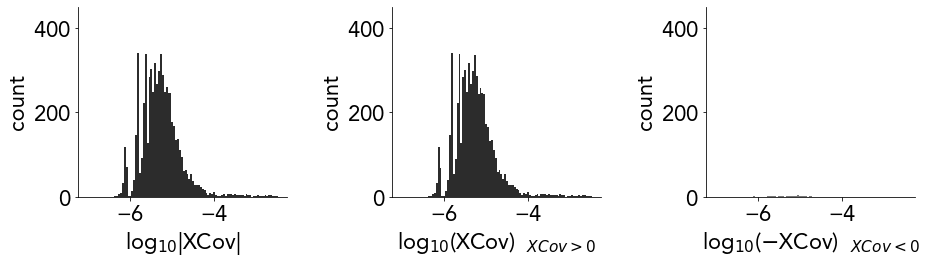

In [38]:
fig,axs=plt.subplots(1,3,figsize=(15,3.5))

mat = np.log10(np.abs(sub_XCov_sign[sub_XCov_sign!=0]))
hist(mat.flatten(), color=colorz[4], bin_range=[-7,-2.5], xlabel='log$_{10}$|XCov|', 
     ylabel='count', ymax=450, ax=axs[0], density=False)


mat = np.log10(np.abs(sub_XCov_sign[sub_XCov_sign>0]))
hist(mat.flatten(), color=colorz[4], bin_range=[-7,-2.5], xlabel='log$_{10}$(XCov)  $_{XCov>0}$', 
     ylabel='count', ymax=450, ax=axs[1], density=False)

mat = np.log10(np.abs(sub_XCov_sign[sub_XCov_sign<0]))
hist(mat.flatten(), color=colorz[5], bin_range=[-7,-2.5], xlabel='log$_{10}$($-$XCov)  $_{XCov<0}$', 
     ylabel='count', ymax=450, ax=axs[2], density=False)


fig.subplots_adjust(wspace=0.5, hspace=0.5)
